![](https://static.helpjuice.com/helpjuice_production/uploads/upload/image/4752/direct/1576239171085-1569423129249-Customer%20Lifetime%20Value.jpg)
image from [link](https://helpjuice.com/blog/increase-customer-lifetime-value)

## What is Customer Lifetime Value(CLV)?

The monetary value a customer will bring to a company during their relationship and communication is known as "customer lifetime value."

We will achieve this by using the formulas below:

* Repeat rate: number of customers who make multiple purchases / all customers
* Churn rate: 1 - repeat rate
* Purchase frequency: total transactions / total number of unique customers 
* Average order value: total price / total transactions 
* Customer value: average order value * purchase frequency
* Profit margin: total price * profit margin rate(provided by the company)
* CLV = (customer value / churn rate) * profit margin

Customers are segmented based on the generated CLV value, and operations are carried out according to these segments.

### Dataset Details

Date of Sales Transaction

Customer ID: Unique customer id for each customer

Transaction ID: ID of the transaction

SKU Category ID: Product Category code

SKU ID: Product code

Quantity Sold: Number of items sold in the transaction

Sales Amount (Unit price times quantity. For unit price, please divide Sales Amount by Quantity.)


In [10]:
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

df = pd.read_csv("/kaggle/input/retail-store-sales-transactions/scanner_data.csv")

In [11]:
# We are trying to understand the data.

def check_df(dataframe, head=7):
    print("################### Shape ####################")
    print(dataframe.shape)
    print("#################### Info #####################")
    print(dataframe.info())
    print("################### Nunique ###################")
    print(dataframe.nunique())
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("################## Quantiles #################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    print("#################### Head ####################")
    print(dataframe.head(head))

check_df(df)

################### Shape ####################
(131706, 8)
#################### Info #####################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131706 entries, 0 to 131705
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      131706 non-null  int64  
 1   Date            131706 non-null  object 
 2   Customer_ID     131706 non-null  int64  
 3   Transaction_ID  131706 non-null  int64  
 4   SKU_Category    131706 non-null  object 
 5   SKU             131706 non-null  object 
 6   Quantity        131706 non-null  float64
 7   Sales_Amount    131706 non-null  float64
dtypes: float64(2), int64(3), object(3)
memory usage: 8.0+ MB
None
################### Nunique ###################
Unnamed: 0        131706
Date                 363
Customer_ID        22625
Transaction_ID     64682
SKU_Category         187
SKU                 5242
Quantity              83
Sales_Amount        3233
dtype: i

In [12]:
# Data Preparation

# We are removing the variable that does not carry any information
df.drop("Unnamed: 0", inplace=True, axis=1) 

# We are finding the unit price of the product.
df["Unit_Price"] = df["Sales_Amount"] / df["Quantity"]

# We are accessing the values required for the formulas.
cltv = df.groupby('Customer_ID').agg({'Transaction_ID': lambda x: x.nunique(),  # total transaction
                                        'Sales_Amount': lambda x: x.sum()})     # total price

# We are changing the names of the variables we have created.
cltv.columns = ['total_transaction', 'total_price']

cltv.head()

,total_transaction,total_price
Customer_ID,,
1,1,16.29000
2,2,22.77000
3,1,10.92000
4,2,33.29000
5,5,78.82000


In [13]:
# Average Order Value (average_order_value = total_price / total_transaction)
cltv["average_order_value"] = cltv["total_price"] / cltv["total_transaction"]

# Purchase Frequency (total_transaction / total_number_of_customers)
cltv.shape[0]  # total number of customers
cltv["purchase_frequency"] = cltv["total_transaction"] / cltv.shape[0]

# Repeat Rate & Churn Rate
# (number of customers who make multiple purchases / all customers)
repeat_rate = cltv[cltv["total_transaction"] > 1].shape[0] / cltv.shape[0]
churn_rate = 1 - repeat_rate

# Profit Margin (total price * profit margin rate)
# We are setting the profit margin rate as 0.10.
cltv['profit_margin'] = cltv['total_price'] * 0.10

# Customer Value (customer_value = average_order_value * purchase_frequency)
cltv['customer_value'] = cltv['average_order_value'] * cltv["purchase_frequency"]

# Customer Lifetime Value (CLV = (customer_value / churn_rate) x profit_margin)
cltv["cltv"] = (cltv["customer_value"] / churn_rate) * cltv["profit_margin"]

cltv.head()

,total_transaction,total_price,average_order_value,purchase_frequency,profit_margin,customer_value,cltv
Customer_ID,,,,,,,
1,1,16.29000,16.29000,0.00004,1.62900,0.00072,0.00230
2,2,22.77000,11.38500,0.00009,2.27700,0.00101,0.00449
3,1,10.92000,10.92000,0.00004,1.09200,0.00048,0.00103
4,2,33.29000,16.64500,0.00009,3.32900,0.00147,0.00961
5,5,78.82000,15.76400,0.00022,7.88200,0.00348,0.05386


In [17]:
# Creating the Segments

# We are dividing the CLTV values into 4 parts and creating a segment variable.
cltv["segment"] = pd.qcut(cltv["cltv"], 4, labels=["D", "C", "B", "A"])

cltv.sort_values(by="cltv", ascending=False).head()


,total_transaction,total_price,average_order_value,purchase_frequency,profit_margin,customer_value,cltv,segment
Customer_ID,,,,,,,,
17471,62,3985.94000,64.28935,0.00274,398.59400,0.17617,137.73487,A
17104,55,3844.97000,69.90855,0.00243,384.49700,0.16994,128.16467,A
17294,39,3798.39000,97.39462,0.00172,379.83900,0.16788,125.07817,A
15540,38,2900.61000,76.33184,0.00168,290.06100,0.12820,72.93921,A
15677,25,2765.16000,110.60640,0.00110,276.51600,0.12222,66.28617,A


In [19]:
# We are creating count, mean, and sum values for all other variables based on the segments.
cltv.groupby("segment").agg({"count", "mean", "sum"})

# Thus, we can perform operations on customers based on their segments.

total_transaction                total_price                         average_order_value                       purchase_frequency                 profit_margin                       customer_value                   cltv                   
                    count    mean    sum       count      mean           sum               count     mean          sum              count    mean     sum         count     mean          sum          count    mean      sum count    mean        sum
segment                                                                                                                                                                                                                                               
D                    5657 1.07212   6065        5657   6.01717   34039.14000                5657  5.75127  32534.92000               5657 0.00005 0.26807          5657  0.60172   3403.91400           5657 0.00027  1.50449  5657 0.00036    2.05829
C                    5656 1.42928   8084        5656  16.02879   90658.85000                5656 12.90350  72982.21736               5656 0.00006 0.35730          5656  1.60288   9065.88500           5656 0.00071  4.00702  5656 0.00236   13.33236
B                    5656 2.36740  13390        5656  39.20595  221748.85000                5656 22.12885 125160.75415               5656 0.00010 0.59182          5656  3.92059  22174.88500           5656 0.00173  9.80105  5656 0.01437   81.27911
A                    5656 6.56701  37143        5656 217.74961 1231591.78000                5656 46.25564 261621.89473               5656 0.00029 1.64168          5656 21.77496 123159.17800           5656 0.00962 54.43500  5656 0.95604 5407.34525

## CLV Prediction with BG-NBD and Gamma-Gamma

***CLTV Prediction: BG/NBD * Gamma gamma submodel***

We are performing CLTV prediction with BG/NBD and Gamma-Gamma.

#### Expected Number of Transactions with BG/NBD.

BG/NBD is used as a standalone sales prediction model, that is; it predicts the expected number of purchases per customer.

The information we need to use in this model and learn from the customer is:

* x: Number of repeated purchases by the customer (more than 1) (frequency)
* tx: Time between a customer's first and last purchase 
* T: Time since the customer's first purchase (customer's age) 


#### Gamma Gamma SubModel

It is used to estimate how much profit a customer can bring per transaction on average.

The information we need to use in this model and learn from the customer is:

* x: Number of repeated purchases by the customer (more than 1) (frequency)
* mx: These are the observed transaction values, i.e., the monetary value, i.e., total price/total transaction.




In [20]:
def check_df(dataframe, head=10):
    print("################### Shape ####################")
    print(dataframe.shape)
    print("#################### Info #####################")
    print(dataframe.info())
    print("################### Nunique ###################")
    print(dataframe.nunique())
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("################## Quantiles #################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    print("#################### Head ####################")
    print(dataframe.head(head))

check_df(df)

################### Shape ####################
(131706, 8)
#################### Info #####################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131706 entries, 0 to 131705
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Date            131706 non-null  object 
 1   Customer_ID     131706 non-null  int64  
 2   Transaction_ID  131706 non-null  int64  
 3   SKU_Category    131706 non-null  object 
 4   SKU             131706 non-null  object 
 5   Quantity        131706 non-null  float64
 6   Sales_Amount    131706 non-null  float64
 7   Unit_Price      131706 non-null  float64
dtypes: float64(3), int64(2), object(3)
memory usage: 8.0+ MB
None
################### Nunique ###################
Date                363
Customer_ID       22625
Transaction_ID    64682
SKU_Category        187
SKU                5242
Quantity             83
Sales_Amount       3233
Unit_Price         4316
dtype: int64
###

In [25]:
# Data Preparation

# We are converting the date in object format to datetime format using the datetime module.
df["Date"] = pd.to_datetime(df["Date"])

# We will find the last date and make transactions starting from 2 days later.
df["Date"].max()  # '31-12-2016'
today_date = pd.to_datetime("2017-01-02")

# We are calculating the necessary values for our calculations.
cltv_pr = df.groupby('Customer_ID').agg(
    {'Date': [lambda InvoiceDate: (InvoiceDate.max() - InvoiceDate.min()).days,  # tx: recency degeri
                     lambda InvoiceDate: (today_date - InvoiceDate.min()).days],         # T: customer's age
     'Transaction_ID': lambda Invoice: Invoice.nunique(),    # x: frequency degeri 
     'Sales_Amount': lambda TotalPrice: TotalPrice.sum()})

# The variables in the output are displayed in two rows. We need to remove the first row.
cltv_pr.columns = cltv_pr.columns.droplevel(0)

# We are changing the names of the variables we have created.
cltv_pr.columns = ['recency', 'T', 'frequency', 'monetary']

# mx: monetary degeri. total price/frequency
cltv_pr["monetary"] = cltv_pr["monetary"] / cltv_pr["frequency"]

# The frequency refers to customers who made more than one purchase.
cltv_pr = cltv_pr[(cltv_pr['frequency'] > 1)]

# We are converting the recency value into weekly time.
cltv_pr["recency"] = cltv_pr["recency"] / 7

# We are converting the customer's age into weekly time.
cltv_pr["T"] = cltv_pr["T"] / 7

cltv_pr.head()

,recency,T,frequency,monetary
Customer_ID,,,,
2,12.42857,40.57143,2,11.38500
4,8.14286,16.14286,2,16.64500
5,27.57143,45.00000,5,15.76400
13,0.14286,8.85714,2,26.62000
14,8.42857,49.85714,4,77.10750


In [27]:
# Setting up the BG-NBD Model

bgf = BetaGeoFitter(penalizer_coef=0.001)

bgf.fit(cltv_pr['frequency'],       
        cltv_pr['recency'],
        cltv_pr['T'])


# Which are the top 10 customers that we expect to have the most purchases within the a month?

cltv_pr["expected_purc_1_month"] = bgf.predict(4,
                                               cltv_pr['frequency'],
                                               cltv_pr['recency'],
                                               cltv_pr['T'])


# What is the expected number of sales for the entire company in 3 months?

cltv_pr["expected_purc_3_month"] = bgf.predict(4 * 3,
                                               cltv_pr['frequency'],
                                               cltv_pr['recency'],
                                               cltv_pr['T'])

cltv_pr.head()

,recency,T,frequency,monetary,expected_purc_1_month,expected_purc_3_month
Customer_ID,,,,,,
2,12.42857,40.57143,2,11.38500,0.06672,0.19284
4,8.14286,16.14286,2,16.64500,0.39384,1.11014
5,27.57143,45.00000,5,15.76400,0.23509,0.68058
13,0.14286,8.85714,2,26.62000,0.35635,0.98885
14,8.42857,49.85714,4,77.10750,0.00385,0.01117


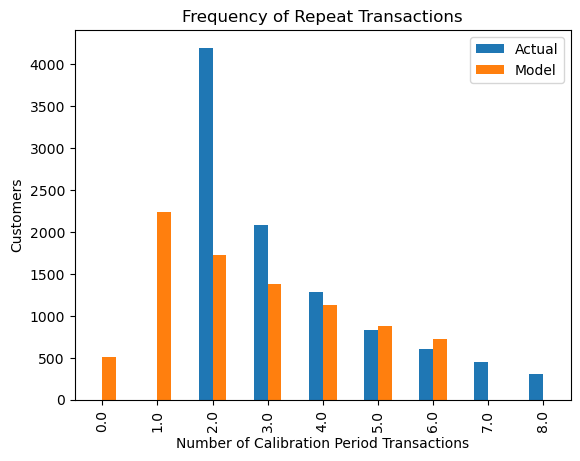

In [28]:
# Evaluation of Prediction Results

plot_period_transactions(bgf)
plt.show()

In [30]:
# Setting up the Gamma-Gamma Model

ggf = GammaGammaFitter(penalizer_coef=0.01)  

ggf.fit(cltv_pr['frequency'], cltv_pr['monetary'])


# We are seeing the profit prediction for customers.
cltv_pr["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_pr['frequency'],
                                                                             cltv_pr['monetary'])


cltv_pr.sort_values("expected_average_profit", ascending=False).head(5)

,recency,T,frequency,monetary,expected_purc_1_month,expected_purc_3_month,expected_average_profit
Customer_ID,,,,,,,
20906,35.57143,51.71429,3,513.91667,0.22570,0.65587,510.46105
5038,4.28571,43.71429,2,318.18000,0.01005,0.02910,315.60281
551,2.28571,50.00000,2,314.08500,0.00326,0.00946,311.56185
14498,48.28571,50.85714,2,307.19000,0.25495,0.74084,304.75786
2127,15.71429,50.71429,4,292.49250,0.02191,0.06362,291.36599


In [32]:
# Calculation of CLV prediction using BG-NBD and GG models.

# CLTV Prediction: BG/NBD * Gamma gamma submodel

#We are calculating the 3-month CLV prediction.
cltv_pred = ggf.customer_lifetime_value(bgf,
                                   cltv_pr['frequency'],
                                   cltv_pr['recency'],
                                   cltv_pr['T'],
                                   cltv_pr['monetary'],
                                   time=3,  
                                   freq="W",  # T and frequency time interval; week(W)
                                   discount_rate=0.01)

cltv_pred = cltv_pred.reset_index()

cltv_pred.head()

,Customer_ID,clv
0,2,2.62881
1,4,21.18705
2,5,11.78906
3,13,29.11969
4,14,0.91743


In [33]:
# We combine CLV predictions with other variables.
cltv_prediction = cltv_pr.merge(cltv_pred, on="Customer_ID", how="left")

cltv_prediction.head()

,Customer_ID,recency,T,frequency,monetary,expected_purc_1_month,expected_purc_3_month,expected_average_profit,clv
0,2,12.42857,40.57143,2,11.38500,0.06672,0.19284,12.85703,2.62881
1,4,8.14286,16.14286,2,16.64500,0.39384,1.11014,18.04761,21.18705
2,5,27.57143,45.00000,5,15.76400,0.23509,0.68058,16.33421,11.78906
3,13,0.14286,8.85714,2,26.62000,0.35635,0.98885,27.89095,29.11969
4,14,8.42857,49.85714,4,77.10750,0.00385,0.01117,77.41181,0.91743


In [34]:
# Creating Segments Based on CLV

# We are dividing the CLV predictions into 4 parts and creating a segment variable.
cltv_prediction["segment"] = pd.qcut(cltv_prediction["clv"], 4, labels=["D", "C", "B", "A"])

cltv_prediction.sort_values(by="clv", ascending=False).head()

,Customer_ID,recency,T,frequency,monetary,expected_purc_1_month,expected_purc_3_month,expected_average_profit,clv,segment
8354,17104,51.14286,51.42857,55,69.90855,3.38903,9.82820,69.93431,729.04232,A
8518,17294,48.57143,51.00000,39,97.39462,2.33569,6.77281,97.41211,699.78592,A
8669,17471,49.14286,51.71429,62,64.28935,3.41387,9.90128,64.31464,675.45225,A
9616,18922,35.42857,35.71429,14,152.20214,1.25843,3.61785,152.14629,583.29343,A
7346,15677,49.57143,51.42857,25,110.60640,1.57883,4.57987,110.61956,537.38648,A


In [36]:
# We are creating count, mean, and sum values for all other variables based on the segments.
cltv_prediction.groupby("segment").agg(
    {"count", "mean", "sum"})


# Thus, we can perform operations on customers based on their segments.

Customer_ID                       recency                          T                       frequency                monetary                       expected_purc_1_month                    expected_purc_3_month                    expected_average_profit                         clv                      
              count        mean       sum   count     mean         sum count     mean          sum     count    mean    sum    count     mean          sum                 count    mean        sum                 count    mean        sum                   count     mean          sum count     mean          sum
segment                                                                                                                                                                                                                                                                                                               
D              2773  8401.02741  23296049    2773  9.16913 25426.00000  2773 42.24275 117139.14286      2773 2.73855   7594     2773 17.21436  47735.41131                  2773 0.04597  127.47824                  2773 0.13247  367.35084                    2773 18.38076  50969.84660  2773  1.50846   4182.95587
C              2772 11460.32179  31768012    2772 24.15182 66948.85714  2772 37.55262 104095.85714      2772 3.21068   8900     2772 14.32866  39719.05651                  2772 0.26583  736.89237                  2772 0.76373 2117.07145                    2772 15.39869  42685.15761  2772  9.02416  25014.97630
B              2772 12891.37085  35734880    2772 27.90538 77353.71429  2772 35.48016  98351.00000      2772 4.46465  12376     2772 19.68276  54560.60356                  2772 0.44499 1233.51070                  2772 1.27473 3533.55935                    2772 20.48681  56789.43774  2772 22.22831  61616.86939
A              2773 14079.06167  39041238    2773 32.12797 89090.85714  2773 36.85544 102200.14286      2773 8.75478  24277     2773 43.05469 119390.65485                  2773 0.74584 2068.22061                  2773 2.14202 5939.82467                    2773 43.45285 120494.76149  2773 83.74465 232223.91030